# supernode-edges

The procedure of constructing weighted L-space and P-space edges of the supernode network.

__Warning!__ Some procedures require 16 cores and up to 10 GB RAM.

Requires:
1. `data/preprocessed/routes.json`
2. `data/supernodes/supernodes.json`

Produces:
1. `data/supernodes/edges_lspace.json`
2. `data/supernodes/edges_pspace_alpha_metrics.json`
3. `data/supernodes/edges_pspace.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import List, Dict
from multiprocessing import Pool
from collections import defaultdict

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from tqdm import tqdm
from scipy import sparse
from matplotlib import pyplot as plt

from myutils.networkx import get_layout
from myutils.spatial import get_earth_distances
from myutils.json import save_json
from myutils.matplotlib import matplotlib_latex, matplotlib_seaborn_style

from ptn.parallel_centralities import shortest_paths_parallel
from config import routes_fpath, supernodes_fpath, edges_lspace_fpath, \
    edges_pspace_alpha_metrics_fpath, edges_pspace_fpath

matplotlib_seaborn_style()
matplotlib_latex()

In [3]:
routes = pd.read_json(routes_fpath).set_index('id')

routes.head(2)

,name,type,direction,stops,distance,supernodes
id,,,,,,
1125,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",5.008430,"[620, 827, 828, 20, 309, 80, 310, 204, 5, 29, ..."
11125,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",3.826103,"[30, 829, 830, 621, 311, 831, 14, 81, 620]"


In [4]:
supernodes = pd.read_json(supernodes_fpath).set_index('id')

supernodes.head(2)

,stops,diameter,types,lat,lon
id,,,,,
0,"[29058, 15366, 1687, 1688, 15385, 2080, 2081, ...",0.732963,"[bus, trolley, tram, subway]",59.85171,30.322415
1,"[18, 18077, 18078, 32036, 16177, 16050, 27063,...",0.909368,"[bus, tram, trolley, subway]",59.95021,30.287937


### L-space

### P-space

In [5]:
coords = supernodes[['lat', 'lon']].values
distances = get_earth_distances(coords, coords)


def get_route_distance(route: List[int]) -> float:
    return distances[route[:-1], route[1:]].sum()

In [71]:
def construct_pspace_graph() -> nx.Graph:
    edges = []

    for route_id, route in routes['supernodes'].iteritems():
        n = len(route)

        for i in range(n - 1):
            for j in range(i + 1, n):
                u = route[i]
                v = route[j]

                if u > v:
                    u, v = v, u

                subroute = route[i : j + 1]
                
                distance = get_route_distance(subroute)
                edges.append((u, v, distance, route_id))

    edges = pd.DataFrame(edges, columns=['u', 'v', 'distance', 'route_id'])\
        .sort_values(by=['u', 'v', 'distance']).drop_duplicates(keep='first')
    
    g = nx.Graph()
    g.add_nodes_from(supernodes.index)
    
    for _, row in edges.iterrows():
        u = int(row['u'])
        v = int(row['v'])
        distance = row['distance']
        route_id = int(row['route_id'])
        
        g.add_edge(u, v, hops=1, distance=distance, route=route_id)
    
    return g

In [72]:
pspace = construct_pspace_graph()

len(pspace), len(pspace.edges), nx.number_connected_components(pspace)

(3202, 118449, 3)

In [73]:
def assign_weights(g: nx.Graph, alpha: float) -> nx.Graph:
    g = g.copy()
    
    distances = pd.Series(nx.get_edge_attributes(g, 'distance'))
    weights = alpha * distances + 1 - alpha
    
    nx.set_edge_attributes(g, weights, 'weight')
    
    return g

In [74]:
edge_distances = nx.get_edge_attributes(pspace, 'distance')

In [10]:
def get_path_distance(path: list) -> float:
    if not isinstance(path, list):
        return np.nan
    
    return sum(
        edge_distances.get((u, v), edge_distances.get((v, u)))
        for u, v in zip(path, path[1:])
    )

In [130]:
def get_lspace_path(pspace: nx.Graph, pspace_path: list) -> list:
    lspace_path = [pspace_path[0]]
    
    for u, v in zip(pspace_path, pspace_path[1:]):
        route_id = pspace[u][v]['route']
        route = routes.loc[route_id, 'supernodes']
        
        start = route.index(u)
        end = route.index(v)
        
        if start < end:
            route_part = route[start + 1:end + 1]
        else:
            route_part = route[start - 1:end:-1] + [route[end]]
        
        lspace_path.extend(route_part)
        
    return lspace_path

In [50]:
pool = Pool(processes=24)

pspace = assign_weights(pspace, alpha=0.00001)
shortest_paths_hops = pd.DataFrame(shortest_paths_parallel(pspace, weight='weight', pool=pool))

pspace = assign_weights(pspace, alpha=0.99999)
shortest_paths_distance = pd.DataFrame(shortest_paths_parallel(pspace, weight='weight', pool=pool))

pool.close()

In [51]:
df = pd.DataFrame()

df['shortest_path_hops'] = shortest_paths_hops.reset_index()\
    .melt(id_vars='index', var_name='column', value_name='shortest_path_hops')\
    .set_index(['index', 'column'])['shortest_path_hops']

df['shortest_path_distance'] = shortest_paths_distance.reset_index()\
    .melt(id_vars='index', var_name='column', value_name='shortest_path_distance')\
    .set_index(['index', 'column'])['shortest_path_distance']

df.index.names = [None, None]
df = df.sort_index()

df.head()

shortest_path_hops shortest_path_distance
0 0                [0]                    [0]
  1         [1, 40, 0]        [1, 40, 228, 0]
  2         [2, 16, 0]             [2, 16, 0]
  3         [3, 37, 0]      [3, 83, 2, 16, 0]
  4         [4, 40, 0]        [4, 40, 228, 0]

In [52]:
df['alpha0_hops'] = df['shortest_path_hops'].apply(lambda l: len(l) if isinstance(l, list) else np.nan)
df['alpha0_distance'] = df['shortest_path_hops'].apply(get_path_distance)

df['alpha1_hops'] = df['shortest_path_distance'].apply(lambda l: len(l) if isinstance(l, list) else np.nan)
df['alpha1_distance'] = df['shortest_path_distance'].apply(get_path_distance)

Text(0.5, -0.22, '(b)')

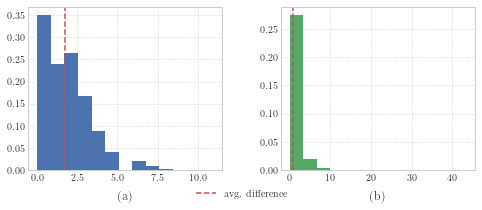

In [242]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(8, 3)
fig.subplots_adjust(wspace=0.3)

mask = df['alpha0_hops'] <= 2

hop_diff = df.loc[mask, 'alpha1_hops'] - df.loc[mask, 'alpha0_hops']

hop_diff.hist(ax=axes[0], bins=13, density=True)
axes[0].axvline(hop_diff.mean(), color='C3', ls='dashed', label='avg. difference')

axes[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.06))

distance_diff = df.loc[mask, 'alpha0_distance'] - df.loc[mask, 'alpha1_distance']

distance_diff.hist(ax=axes[1], bins=13, density=True, color='C2')
axes[1].axvline(distance_diff.mean(), color='C3', ls='dashed')

axes[0].set_title('(a)', y=-0.22)
axes[1].set_title('(b)', y=-0.22)

In [235]:
def build_line_graph(nodes: list) -> nx.Graph:
    g = nx.Graph()
    g.add_edges_from(zip(nodes, nodes[1:]))
    
    return g

In [236]:
def build_lspace_path(pspace_path: list) -> tuple:
    lspace_path = get_lspace_path(pspace, pspace_path)
    g = build_line_graph(lspace_path)
    
    sizes = pd.Series(0, index=set(lspace_path))
    sizes[pspace_path] = 15
    sizes = sizes.values
    
    return g, sizes

In [237]:
pos = dict(zip(supernodes.index, supernodes[['lon', 'lat']].values))

In [243]:
u, v = distance_diff.index[distance_diff.argmax()]
row = df.loc[(u, v)]

p1 = row['shortest_path_hops']
p1_lspace, p1_sizes = build_lspace_path(p1)

p2 = row['shortest_path_distance']
p2_lspace, p2_sizes = build_lspace_path(p2)

row

shortest_path_hops              [2717, 2713]
shortest_path_distance    [2717, 1473, 2713]
alpha0_hops                              2.0
alpha0_distance                    44.689759
alpha1_hops                              3.0
alpha1_distance                     1.301548
Name: (2713, 2717), dtype: object

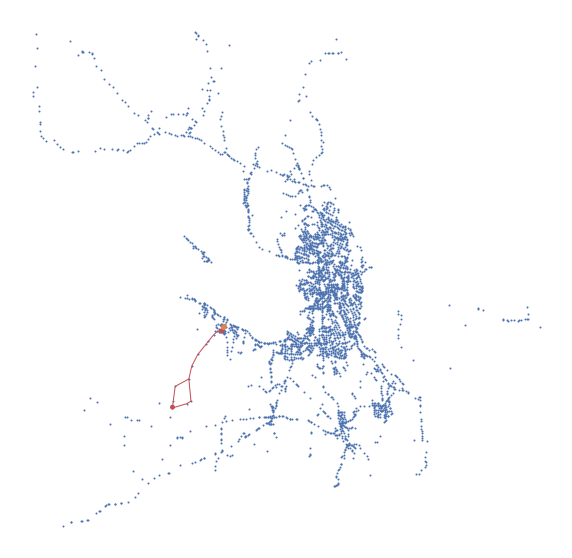

In [244]:
plt.figure(figsize=(10, 10))

plt.scatter(*supernodes[['lon', 'lat']].values.T, s=1, zorder=-1)

nx.draw(p1_lspace, pos, node_size=p1_sizes, width=1, node_color='C3', edge_color='C3')
nx.draw(p2_lspace, pos, node_size=p2_sizes, width=1, node_color='C1', edge_color='C1')

In [245]:
u, v = hop_diff.index[hop_diff.argmax()]
row = df.loc[(u, v)]

p1 = row['shortest_path_hops']
p1_lspace, p1_sizes = build_lspace_path(p1)

p2 = row['shortest_path_distance']
p2_lspace, p2_sizes = build_lspace_path(p2)

row

shortest_path_hops                                              [2215, 134]
shortest_path_distance    [2215, 352, 1161, 653, 88, 2167, 343, 223, 219...
alpha0_hops                                                             2.0
alpha0_distance                                                   16.920301
alpha1_hops                                                            13.0
alpha1_distance                                                    12.30368
Name: (134, 2215), dtype: object

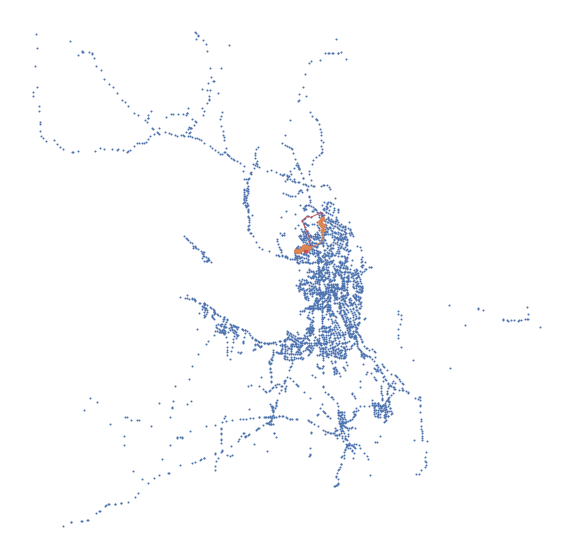

In [246]:
plt.figure(figsize=(10, 10))

plt.scatter(*supernodes[['lon', 'lat']].values.T, s=1, zorder=-1)

nx.draw(p1_lspace, pos, node_size=p1_sizes, width=1, node_color='C3', edge_color='C3')
nx.draw(p2_lspace, pos, node_size=p2_sizes, width=1, node_color='C1', edge_color='C1')

In [15]:
minimal_hops = df['alpha0_hops'].copy()
minimal_distances = df['alpha1_distance'].copy()

In [16]:
pool = Pool(processes=24)
mapes = []

alphas = np.concatenate([
    np.linspace(0.00001, 0.05, 5),
    np.linspace(0.05, 0.95, 12)[1:-1],
    np.linspace(0.95, 0.99999, 5),
])

for alpha in tqdm(alphas):
    pspace = assign_weights(pspace, alpha)
    
    shortest_paths = pd.DataFrame(shortest_paths_parallel(pspace, weight='weight', pool=pool))

    shortest_paths = shortest_paths.reset_index()\
        .melt(id_vars='index', var_name='column', value_name='shortest_path')\
        .set_index(['index', 'column'])['shortest_path']

    shortest_paths.index.names = [None, None]
    shortest_paths = shortest_paths.sort_index()
    
    shortest_path_hops = shortest_paths.apply(lambda l: len(l) if isinstance(l, list) else np.nan)
    shortest_path_distances = shortest_paths.apply(get_path_distance)
    
    hop_mape = ((shortest_path_hops - minimal_hops) / minimal_hops).mean()
    distances_mape = ((shortest_path_distances - minimal_distances) / minimal_distances).mean()
    
    mapes.append((alpha, hop_mape, distances_mape))
    
mapes = pd.DataFrame(mapes, columns=['alpha', 'hops_mape', 'distance_mape'])
    
pool.close()

100%|██████████| 20/20 [35:28<00:00, 106.40s/it]


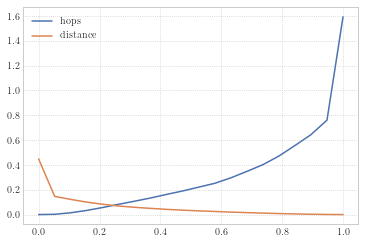

In [20]:
plt.plot(mapes['alpha'], mapes['hops_mape'], label='hops')
plt.plot(mapes['alpha'], mapes['distance_mape'], label='distance')

plt.legend()

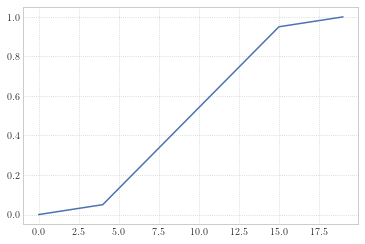

In [221]:
alphas = np.concatenate([
    np.linspace(0.00001, 0.05, 5),
    np.linspace(0.05, 0.95, 12)[1:-1],
    np.linspace(0.95, 0.99999, 5),
])

plt.plot(alphas)

In [ ]:
alphas = [0.001, ]

In [213]:
np.linspace(0, 1, 20)

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [ ]:
metrics = pd.read_json(edges_pspace_alpha_metrics_fpath).set_index('alpha')

metrics.head(2)

In [ ]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(8, 3)
fig.subplots_adjust(wspace=0.3)

markers = ['o', 'v']
linestyles = ['solid', 'dashed']

for i, metric, ax in zip(range(2), ['distance', 'hops'], axes):
    color = f'C{i}'
    marker = markers[i]
    linestyle = linestyles[i]
    
    # ax.plot(metrics[f'{metric}_mean'], c=color, lw=0.8, marker='.', markersize=3)
#     ax.fill_between(
#         metrics.index,
#         metrics[f'{metric}_t1'],
#         metrics[f'{metric}_t2'],
#         color=color,
#         alpha=0.15,
#     )
    
    ax.plot(metrics[f'{metric}_median'], c=color, lw=0.8, ls=linestyle, marker=marker, markersize=3)
    
    # ax.set_title(metric)
    ax.set_xlabel('$\\alpha$')
    
axes[0].set_ylabel('distance, km')
axes[0].set_title('(a)', y=-0.3)
axes[1].set_ylabel('hops')
axes[1].set_title('(b)', y=-0.3)

plt.savefig('../figures/weight_alpha_metrics.pdf', transparent=True, bbox_inches='tight')

In [ ]:
edges = construct_pspace_edges(alpha=0.33)

edges[:5]

In [ ]:
weighted_edges = [(edge['u'], edge['v'], edge['w']) for edge in edges]

g = nx.Graph()
g.add_weighted_edges_from(weighted_edges)

len(g), len(g.edges)

In [ ]:
pos = dict(zip(supernodes.index, supernodes[['lon', 'lat']].values))

In [ ]:
components = sorted(nx.connected_components(g.to_undirected()), key=len, reverse=True)

sizes = [0.5, 2, 2]
markers = ['o', 'v', 's']

In [ ]:
plt.figure(figsize=(6, 4))

handles = []
labels = []

for i, comp in enumerate(components):
    color = f'C{i}'
    marker = markers[i]
    size = sizes[i]
    
    nx.draw(g.subgraph(comp), pos, node_size=size, width=0.005, node_color=color, node_shape=marker)
    
    labels.append(f'connected component {i + 1}')
    handles.append(plt.Line2D([0], [0], color=color, linewidth=0, marker=marker, markersize=size))

plt.legend(handles=handles, labels=labels, loc='upper right')
    
plt.savefig('../figures/pspace_edges.png', dpi=250, transparent=True, bbox_inches='tight')

In [ ]:
save_json(edges, edges_pspace_fpath)